In [ ]:
# Standard library
import importlib
import math

# Third-party libraries
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from scipy.stats import norm
import seaborn as sns
from tqdm import tqdm

# Local modules
import gm_utils
importlib.reload(gm_utils)  # Forces Python to reload updated gm_utils.py
from gm_utils import visualize_density, sample, geodesic, energy
from curves import CubicSpline

# Matplotlib settings
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'


In [26]:
x_points = np.array([0, 1, 2, 3])
y_points = np.array([0, 2, 4, 6])
f = interp1d(x_points, y_points)

LAMBDA_MIN, LAMBDA_MAX = -30, 30 

def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t


def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t


def gaussian_mixture_density(x, t):
    """Analytical implementation of the marginal log-density at time t"""
    alpha_t, sigma_t = alpha_sigma(t)
    means_t = alpha_t[:, None] * original_means[None, :]

    variances_t = sigma_t[:, None]**2 + alpha_t[:, None]**2 * original_variance
    log_probs = torch.log(weights[None, :]) - 0.5 * (torch.log(2 * torch.pi * variances_t) + (x[:, None] - means_t)**2 / variances_t)
    log_p_t = torch.logsumexp(log_probs, dim=1)
    return log_p_t


def compute_vector_field(x, t):
    """Implementation of the PF-ODE vector field"""
    alpha_t, sigma_t = alpha_sigma(t)
    f_t = 0.5 * (LAMBDA_MIN - LAMBDA_MAX) * sigma_t**2
    g2_t = (LAMBDA_MAX - LAMBDA_MIN) * sigma_t**2
    
    x.requires_grad_(True)
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]
    
    dx = f_t * x - 0.5 * g2_t * grad_log_p_t
    dt = -torch.ones_like(dx)
    return dt.detach().cpu().numpy(), dx.detach().cpu().numpy()

def sample(x, n_steps, t_start=1, t_end=0):
    """PF-ODE sampling"""
    t = t_start * torch.ones_like(x)
    dt_val = (t_start - t_end) / n_steps
    all_x = [x.detach().numpy()]
    all_t = [t.detach().numpy()]
    for i in range(n_steps):
        dt, dx = compute_vector_field(x, t)
        dt, dx = torch.from_numpy(dt), torch.from_numpy(dx)
        x = x + dt * dx * dt_val
        t = t + dt * dt_val
        all_x.append(x.detach().numpy())
        all_t.append(t.detach().numpy())
    return np.array(all_t), np.array(all_x)

def eds(t, x):
    """Implementation of the denoising mean, or Expected Denoised Sample (EDS) - based on Tweedie formula using the score function - Eq61 in the paper"""
    assert t.shape == x.shape
    assert t.ndim == 1
    alpha_t, sigma_t = alpha_sigma(t)    
    x.requires_grad_(True)
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]
    res = (x + sigma_t ** 2 * grad_log_p_t)
    res = res / alpha_t
    return res

def mu(theta):
    """
    Implementation of the expectation parameter - Eq 22 in the paper. Since our data distribution is 1D, the spacetime is 2D
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    mu_t : torch.Tensor
        `time` component of the expectation parameter - tensor or shape (N,)
    mu_x : torch.Tensor
        `space` component of the expectation parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    x.requires_grad_(True)
    f = eds(t, x)
    div = torch.autograd.grad(f.sum(), x, create_graph=True)[0] # In 1D the divergence is just the derivative
    mu_t, mu_x = sigma_t ** 2 / alpha_t * div + f ** 2, f
    return mu_t, mu_x

def eta(theta):
    """
    Implementation of the natural parameter - Eq 18 in the paper.
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    eta_t : torch.Tensor
        `time` component of the natural parameter - tensor or shape (N,)
    eta_x : torch.Tensor
        `space` component of the natural parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    return -0.5 * alpha_t**2/sigma_t**2, alpha_t/sigma_t**2 * x



def energy(theta):
    """
    Implementation of the energy of a discretized curve - Eq 23 in the paper.
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    energy : torch.Tensor
        Energy represented as tensor of shape (,)
    """
    mu_t, mu_x = mu(theta)
    eta_t, eta_x = eta(theta)
    energies = (mu_t[1:] - mu_t[:-1]) * (eta_t[1:] - eta_t[:-1]) + (mu_x[1:] - mu_x[:-1]) * (eta_x[1:] - eta_x[:-1])
    return energies.sum()

def geodesic(theta1, theta2, n_opt_steps, num_intermediate_points, num_nodes=20):
    """
    Implementation of approximate geodesic, parametrizes the curve as a CubicSpline and minimizes its energy w.r.t. curve's parameters using Adam optimizer
    Parameters
    ----------
    theta1: torch.Tensor
        First endpoint of the curve, represented as a point in spacetime, i.e. (2,) tensor
    theta2: torch.Tensor
        Second endpoint of the curve, represented as a point in spacetime, i.e. (2,) tensor
    n_opt_steps : int
        Number of optimization steps
    num_intermediate_points : int
        Number of points to discretize the curve into (in the paper: `N`)
    num_nodes : int
        Parameter of the CubicSpline. The higher the number of nodes, the more flexible/expressive the curve
    """
    curve = CubicSpline(begin=theta1, end=theta2, num_nodes=num_nodes)
    optimizer = torch.optim.Adam(curve.parameters(), lr=1e-1)
    t_tensor = torch.linspace(0, 1, num_intermediate_points).unsqueeze(0)
    for step_id in tqdm.tqdm(range(n_opt_steps)):
        optimizer.zero_grad()
        theta = curve(t_tensor)[0]
        loss = energy(theta)
        loss.backward()
        optimizer.step()
    return curve(t_tensor)[0].detach().numpy()



def score_function(x, t):
    """Gradient of log p_t(x) w.r.t. x (the score)."""
    x = torch.tensor([x], dtype=torch.float32, requires_grad=True)
    t = torch.tensor([t], dtype=torch.float32)
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x)[0]
    return grad_log_p_t.item()



def plot_ode_geodesics(points):

    for i, x in enumerate(points):
        pf_ode_sample = sample(x, 512, t_start=1., t_end=t_min)
        pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
        print('Energy of pf ode trajectory:', energy(pf_ode_theta).item(), end=' ')
        theta1 = pf_ode_theta[0]
        theta2 = pf_ode_theta[-1]
        print('theta1', theta1)
        print('theta2', theta2)
        #theta1 = torch.tensor([0.00001, 2.2128]) #(theta=(t, x))
        #theta2 = torch.tensor([0.9999, 3.5])
        shortest_path12 = geodesic(theta1, theta2, n_opt_steps=1000, num_intermediate_points=128, num_nodes=2)
        print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())
        if i == 0:
            label_pf = 'PF-ODE trajectory'
            label_g = 'Spacetime Geodesic'
        else:
            label_pf = None
            label_g = None
        ax.plot(pf_ode_theta[:, 0], pf_ode_theta[:, 1], color='C3', label=label_pf)
        ax.plot(shortest_path12[:, 0], shortest_path12[:, 1], color='C3', linestyle='--', label=label_g)


 
def visualize_density(ax):
    """Estimates the marginal log-densities and visualizes it as background for the spacetime - used for both Fig1, and Fig5"""
    n_time_points = 50
    n_space_points = 200

    t_vals = torch.linspace(0, 1, n_time_points)
    x_vals = torch.linspace(-1.5, 1.5, n_space_points)
    T, X = np.meshgrid(t_vals.numpy(), x_vals.numpy())
    
    T_flat = T.flatten()
    X_flat = X.flatten()
    densities = gaussian_mixture_density(torch.from_numpy(X_flat), torch.from_numpy(T_flat)).reshape(X.shape).detach()
        
    ax.contourf(T, X, (densities).reshape(X.shape), levels=25, cmap='viridis', alpha=0.8)


In [18]:
def sample_trajectory_points(n_trajectories=100, n_steps=512, n_points_per_trajectory=10, 
                           x_range=(-2, 2), t_start=1.0, t_end=0, seed=None):
    """
    Sample points along multiple PF-ODE trajectories.
    
    Parameters:
    -----------
    n_trajectories : int
        Number of different trajectories to generate
    n_steps : int  
        Number of integration steps per trajectory
    n_points_per_trajectory : int
        Number of points to sample from each trajectory
    x_range : tuple
        Range of initial x values to sample from
    t_start, t_end : float
        Start and end times for the ODE integration
    seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    sampled_points : torch.Tensor
        Shape (n_trajectories * n_points_per_trajectory, 2) where each row is (t, x)
    trajectory_ids : torch.Tensor
        Shape (n_trajectories * n_points_per_trajectory,) indicating which trajectory each point came from
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    all_sampled_points = []
    all_trajectory_ids = []
    
    for traj_id in range(n_trajectories):
        x_init = torch.tensor([np.random.uniform(*x_range)], dtype=torch.float32)
        t_trajectory, x_trajectory = sample(x_init, n_steps, t_start, t_end)
        
        # Combine into spacetime points (t, x)
        trajectory_points = torch.from_numpy(np.column_stack([
            t_trajectory.flatten(), 
            x_trajectory.flatten()
        ]))
        
        # Sample n_points_per_trajectory random points from this trajectory
        if len(trajectory_points) >= n_points_per_trajectory:
            indices = torch.randperm(len(trajectory_points))[:n_points_per_trajectory]
            sampled_points = trajectory_points[indices]
        else:
            sampled_points = trajectory_points
            
        all_sampled_points.append(sampled_points)
        all_trajectory_ids.append(torch.full((len(sampled_points),), traj_id))
    
    sampled_points = torch.cat(all_sampled_points, dim=0)
    trajectory_ids = torch.cat(all_trajectory_ids, dim=0)
    
    return sampled_points, trajectory_ids


def visualize_sampled_points():
    """Example of how to use the sampling functions and visualize results"""
    
    # Sample points using both methods
    points1, traj_ids1 = sample_trajectory_points(
        n_trajectories=20,
        n_points_per_trajectory=15,
        seed=42
    )

    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(6, 4))
    
    # Plot method 1: Random sampling from trajectories
    visualize_density(ax1)
    scatter1 = ax1.scatter(
        points1[:, 0],
        points1[:, 1],
        c=traj_ids1,
        s=20,
        alpha=0.7,
        cmap='tab10'
    )
    
    ax1.set_title('Random Sampling from Trajectories')
    ax1.set_xlabel('Time t')
    ax1.set_ylabel('Space x')
    
    plt.tight_layout()
    plt.show()
        
    return 

## Metric and Sectional curvature

In [ ]:
def metric_tensor_differentiable(theta):
    """
    theta : torch.Tensor
        Shape (N, 2), each row = (t, x_t)
    
    Returns:
    --------
    I : torch.Tensor
        Shape (N, 2, 2), metric tensor at each spacetime point
    """
    theta = theta.clone().detach().requires_grad_(True)
    N = theta.shape[0]

    eta_t, eta_x = eta(theta)
    mu_t, mu_x = mu(theta)

    eta_vec = torch.stack([eta_t, eta_x], dim=1)  
    mu_vec = torch.stack([mu_t, mu_x], dim=1)     #

    I_batch = torch.zeros((N, 2, 2), dtype=theta.dtype, device=theta.device)

    for n in range(N):
        # Compute Jacobians J_eta and J_mu
        J_eta = torch.zeros((2, 2), dtype=theta.dtype, device=theta.device)
        J_mu = torch.zeros((2, 2), dtype=theta.dtype, device=theta.device)

        for k in range(2):
            grad_eta_k = torch.autograd.grad(
                eta_vec[n, k], theta, retain_graph=True, create_graph=True
            )[0][n]  # gradient w.r.t. θ for η_k
            grad_mu_k = torch.autograd.grad(
                mu_vec[n, k], theta, retain_graph=True, create_graph=True
            )[0][n]  # gradient w.r.t. θ for μ_k

            J_eta[k, :] = grad_eta_k
            J_mu[k, :] = grad_mu_k

        #print('Jacobian eta:',J_eta,'Jacobian J_mu:', J_mu)
        I_batch[n] = J_eta.T @ J_mu

    return I_batch, theta 

def compute_sectional_curvature(theta):
    """
    theta : torch.Tensor
        Shape (N, 2), coordinates (t, x_t)
    """

    g, theta_diff = metric_tensor_differentiable(theta)
    N = g.shape[0]
    g_inv = torch.inverse(g)  

    christoffel = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)
    g_derivs = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)

    #Compute all the derivatives of the metric
    for n in range(N):
        for i in range(2):
            for j in range(2):
                
                grad_outputs = torch.zeros_like(g[n, i, j])
                grad_outputs = grad_outputs + 1.0

                grad_g_ij = torch.autograd.grad(
                    g[n, i, j], theta_diff,
                    grad_outputs=grad_outputs,
                    retain_graph=True,
                    create_graph=True,
                    only_inputs=True
                )[0][n]  

                g_derivs[n, i, j, :] = grad_g_ij

    # Compute Christoffel symbols: Γ^k_ij 
    for n in range(N):
        for k in range(2):
            for i in range(2):
                for j in range(2):
                    sum_term = 0.0
                    for l in range(2):
                        bracket_term = (g_derivs[n, i, l, j] +    
                                       g_derivs[n, j, l, i] -     
                                       g_derivs[n, i, j, l])      
                        sum_term += g_inv[n, k, l] * bracket_term

                    christoffel[n, k, i, j] = 0.5 * sum_term

    # Compute Riemann tensor component R^1_212

    R_1212 = torch.zeros(N, dtype=theta.dtype, device=theta.device)

    for n in range(N):
        # i, j, k, l = 0, 1, 0, 1  
        i, j, k, l = 0, 1, 0, 1

        if christoffel[n, i, j, l].requires_grad:
            dchrist_jl_k = torch.autograd.grad(
                christoffel[n, i, j, l], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, l]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, k]
        else:
            dchrist_jl_k = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        if christoffel[n, i, j, k].requires_grad:
            dchrist_jk_l = torch.autograd.grad(
                christoffel[n, i, j, k], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, k]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, l]
        else:
            dchrist_jk_l = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        
        quad1 = sum(christoffel[n, i, m, k] * christoffel[n, m, j, l] for m in range(2))
        quad2 = sum(christoffel[n, i, m, l] * christoffel[n, m, j, k] for m in range(2))

        R_1212[n] = dchrist_jl_k - dchrist_jk_l + quad1 - quad2

   
    # Compute the missing upper-index component R^1_101
    R_2212 = torch.zeros(N, dtype=theta.dtype, device=theta.device) 

    for n in range(N):
        i2, j2, k2, l2 = 1, 1, 0, 1 
        if christoffel[n, i2, j2, l2].requires_grad:
            dchrist_jl_k_2 = torch.autograd.grad(
                christoffel[n, i2, j2, l2], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i2, j2, l2]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, k2]
        else:
            dchrist_jl_k_2 = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        if christoffel[n, i2, j2, k2].requires_grad:
            dchrist_jk_l_2 = torch.autograd.grad(
                christoffel[n, i2, j2, k2], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i2, j2, k2]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, l2]
        else:
            dchrist_jk_l_2 = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        quad1_2 = sum(christoffel[n, i2, m, k2] * christoffel[n, m, j2, l2] for m in range(2))
        quad2_2 = sum(christoffel[n, i2, m, l2] * christoffel[n, m, j2, k2] for m in range(2))

        R_2212[n] = dchrist_jl_k_2 - dchrist_jk_l_2 + quad1_2 - quad2_2

    # Lower the indices by multiplying with the metric:
    #print('R1212', R_1212)
    #print('R1012', R_up_i1)
    R_lowered_1212 = g[:, 0, 0] * R_1212 + g[:, 0, 1] * R_2212
    #print('first metric:', g[:, 0, 0])
    #print(R_lowered_1212, torch.det(g)  )

    # Sectional curvature K = R_{1212} / det(g) for 2D manifold (use lowered component)
    
    det_g = torch.det(g)  # (N,)
    K = R_lowered_1212 / det_g

    return K


print('sectional 3', compute_sectional_curvature(torch.tensor([[0.2, -0.4]])))



## Visualisations

Energy of pf ode trajectory: 0.9429628849029541 theta1 tensor([1., 1.])
theta2 tensor([0.1000, 0.7064])


100%|██████████| 1000/1000 [00:03<00:00, 264.69it/s]


Energy of a geodesic: 60.093685150146484
Energy of pf ode trajectory: 1.0736794471740723 theta1 tensor([1.0000, 0.2000])
theta2 tensor([0.1000, 0.1413])


100%|██████████| 1000/1000 [00:03<00:00, 294.05it/s]


Energy of a geodesic: 11.917082786560059
Energy of pf ode trajectory: 0.9429628849029541 theta1 tensor([ 1., -1.])
theta2 tensor([ 0.1000, -0.7064])


100%|██████████| 1000/1000 [00:03<00:00, 293.74it/s]


Energy of a geodesic: 60.093685150146484


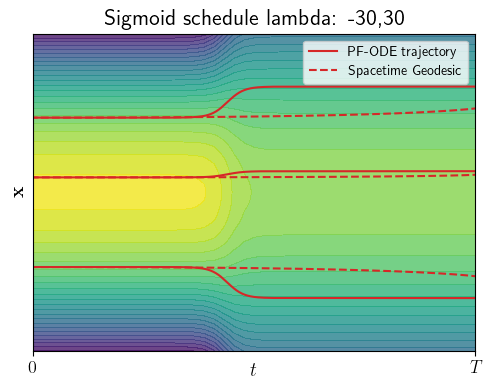

metric dif (tensor([[[237.5000,  -5.0000],
         [ -5.0000,   0.6667]]], grad_fn=<CopySlices>), tensor([[0.5000, 0.3000]], requires_grad=True))


In [28]:
original_means = torch.tensor([0], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.5, dtype=torch.float32) #0.4
weights = torch.tensor([1], dtype=torch.float32)


fig, ax = plt.subplots(figsize=(5, 4))
t_min = 0.1
visualize_density(ax)

plot_ode_geodesics(torch.tensor([[1.], [0.2], [-1]]))

ax.legend()
ax.set_xlim((t_min, 1))
ax.set_xticks([t_min, 1], [r'$0$', r'$T$'], fontsize=13)
ax.set_yticks([])
ax.set_xlabel(r'$t$', fontsize=14, labelpad=-10)
ax.set_ylabel(r'$\mathbf{x}$', fontsize=14)
ax.set_title('Sigmoid schedule lambda: -30,30', fontsize=16)
plt.tight_layout()
plt.show()

print('metric dif', metric_tensor_differentiable(torch.tensor([[0.5, 0.3]])))


Testing trajectory point sampling...


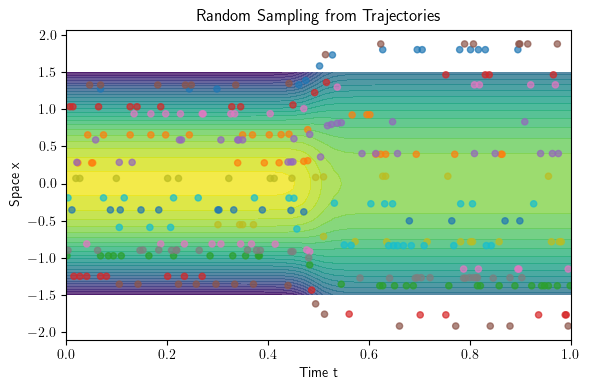

In [30]:
# Test the trajectory sampling functions
print("Testing trajectory point sampling...")

# Generate sampled points
sampled_points, trajectory_ids = sample_trajectory_points(
    n_trajectories=30, 
    n_points_per_trajectory=20, 
    x_range=(-1,1),
    seed=42
)


# Visualize the results
visualize_sampled_points()

100%|██████████| 200/200 [00:09<00:00, 20.46it/s]

C:\Users\maria\AppData\Local\Temp\ipykernel_24404\1588825234.py:72: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim((-1.1 * max_pdf, 0))
C:\Users\maria\AppData\Local\Temp\ipykernel_24404\1588825234.py:72: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim((-1.1 * max_pdf, 0))


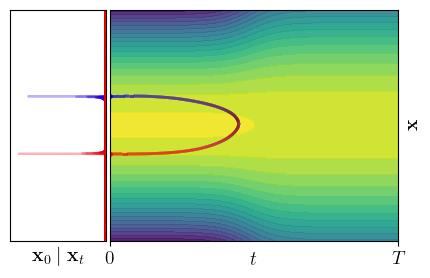

In [ ]:
theta1 = torch.tensor([0.001, 1]) #(theta=(t, x))
theta2 = torch.tensor([0.001, -1])

num_discretization_points = 10000
num_optimization_steps = 200

shortest_path12 = geodesic(theta1, theta2, num_optimization_steps, num_discretization_points, num_nodes=200)


def get_means_and_variances(t, x):
    """
    When the data distribution p0 is a Gaussian mixture, then for every (t, xt), the `denoising distribution` (Eq 15 in the paper) is also a Gaussian Mixture. This function calculates the means and std of the denoising distribution in our Gaussian Mixture toy example. This function is used only to visualize the transition of densities in Figure 1.
    """
    alpha, sigma = alpha_sigma(t)
    snr = log_SNR(t).exp()
    variance_inv = 1 / original_variance + snr
    variance = 1 / variance_inv
    means = original_means/original_variance + alpha/sigma ** 2 * x
    return (means * variance).numpy(), variance.numpy()


def visualize_density_w_geodesic(ax):
    visualize_density(ax)
    ax.set_xlabel(r"$t$", labelpad=-12, fontsize=14)
    ax.set_yticks([])
    ax.set_xticks([0, 1], [r'$0$', r'$T$'], fontsize=14)
    ax.scatter(*theta1.numpy(), color='blue', s=5)
    ax.scatter(*theta2.numpy(), color='red', s=5)

    points = shortest_path12

    segments = np.concatenate([points[:-1, None], points[1:, None]], axis=1)
    norm = plt.Normalize(0, len(points) - 1)
    cmap = LinearSegmentedColormap.from_list('blue_red_gradient', ['blue', 'red'], N=len(points))

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(np.arange(len(points)))
    lc.set_linewidth(2)

    ax.add_collection(lc)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_ylabel(r"$\mathbf{x}$", fontsize=14)
fig, (ax2, ax1) = plt.subplots(ncols=2, figsize=(5, 3), width_ratios=[1, 3])

visualize_density_w_geodesic(ax1)

num_plots = num_discretization_points

cmap = LinearSegmentedColormap.from_list('blue_red_gradient', ['blue', 'red'], N=num_plots)
colors = [cmap(i / (num_plots - 1)) for i in range(num_plots)]

indices = np.round(np.linspace(0, num_plots - 1, num_plots)).astype(np.int32)
x = np.linspace(-6, 8, 1000)
max_pdf = 0

for idx in range(num_plots):
    theta = torch.from_numpy(shortest_path12[idx])
    mean, var = get_means_and_variances(theta[0], theta[1])
    pdf = np.zeros_like(x)
    for mean_i, weight_i in zip(mean, weights):
        pdf += weight_i.item() * norm.pdf(x, loc=mean_i, scale=var ** 0.5)
    pdf = pdf
    max_pdf = max(max_pdf, np.max(pdf))
    if idx == 0 or idx == num_plots - 1:
        alpha = 1
    else:
        alpha = 0.3
    ax2.plot(-pdf, x, color=colors[idx], alpha=alpha)
    ax2.set_ylim((-4, 4))
    ax2.set_xlim((-1.1 * max_pdf, 0))

ax2.set_xlabel(r'$\mathbf{x}_0 \mid \mathbf{x}_t$', fontsize=14)
ax2.set_xticks([])
ax2.set_yticks([])
plt.subplots_adjust(wspace=0.02)

sectional curvature at t=0.10, xt=-0.60: nan
sectional curvature at t=0.10, xt=-0.54: nan
sectional curvature at t=0.10, xt=-0.47: nan
sectional curvature at t=0.10, xt=-0.41: nan
sectional curvature at t=0.10, xt=-0.35: nan
sectional curvature at t=0.10, xt=-0.28: nan
sectional curvature at t=0.10, xt=-0.22: nan
sectional curvature at t=0.10, xt=-0.16: nan
sectional curvature at t=0.10, xt=-0.09: nan
sectional curvature at t=0.10, xt=-0.03: nan
sectional curvature at t=0.10, xt=0.03: nan
sectional curvature at t=0.10, xt=0.09: nan
sectional curvature at t=0.10, xt=0.16: nan
sectional curvature at t=0.10, xt=0.22: nan
sectional curvature at t=0.10, xt=0.28: nan
sectional curvature at t=0.10, xt=0.35: nan
sectional curvature at t=0.10, xt=0.41: nan
sectional curvature at t=0.10, xt=0.47: nan
sectional curvature at t=0.10, xt=0.54: nan
sectional curvature at t=0.10, xt=0.60: nan
sectional curvature at t=0.13, xt=-0.60: nan
sectional curvature at t=0.13, xt=-0.54: nan
sectional curvature 

100%|██████████| 1000/1000 [00:10<00:00, 95.50it/s]


Energy of a geodesic: -107.25186920166016


C:\Users\maria\AppData\Local\Temp\ipykernel_24404\3631020506.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 500x500 with 0 Axes>

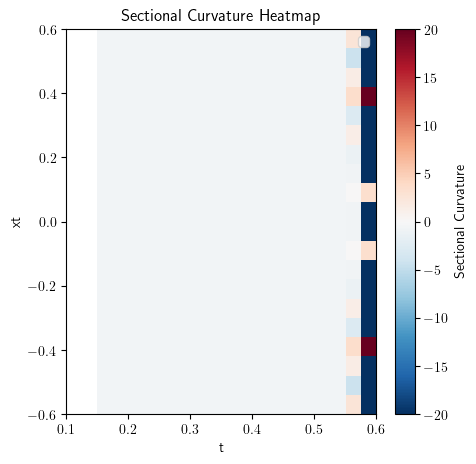

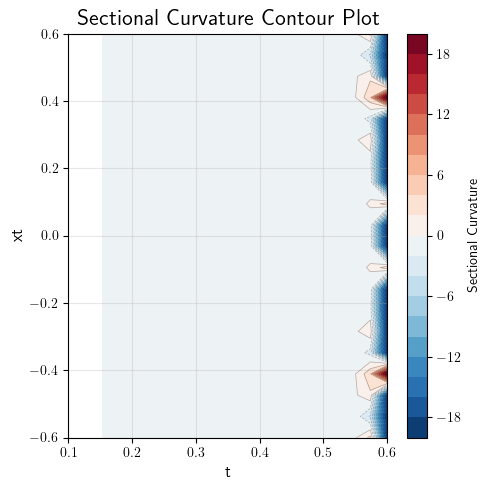


Heatmap computed with:
- t range: 0.1 to 0.6 (20 points)
- xt range: -0.6 to 0.6 (20 points)
- Curvature range: nan to nan


In [32]:
t_range = np.linspace(0.1, 0.6,20)  
xt_range = np.linspace(-0.6, 0.6, 20)    
T, XT = np.meshgrid(t_range, xt_range)

curvature_values = np.zeros_like(T)

for i, t in enumerate(t_range):
    for j, xt in enumerate(xt_range):
        tensor_input = torch.tensor([[t, xt]], dtype=torch.float32)
        curvature = compute_sectional_curvature(tensor_input)
        if torch.is_tensor(curvature):
            curvature_values[j, i] = curvature.item()
        else:
            curvature_values[j, i] = curvature
        
        if curvature_values[j, i] > 20:
            curvature_values[j, i] = 20

        if curvature_values[j, i] < -20:
            curvature_values[j, i] = -20

        print(f'sectional curvature at t={t:.2f}, xt={xt:.2f}: {curvature_values[j, i]:.4f}')

plt.figure(figsize=(5, 5))

for i, x in enumerate(torch.tensor([[1.]])):
    pf_ode_sample = sample(x, 512, t_start=0.5, t_end=t_min)
    pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
    print('Energy of pf ode trajectory:', energy(pf_ode_theta).item(), end=' ')
    theta1 = pf_ode_theta[0]
    theta2 = pf_ode_theta[-1]
    print('theta1', theta1)
    print('theta2', theta2)
    #theta1 = torch.tensor([0.00001, 2.2128]) #(theta=(t, x))
    #theta2 = torch.tensor([0.9999, 3.5])
    shortest_path12 = geodesic(theta1, theta2, n_opt_steps=1000, num_intermediate_points=128, num_nodes=2)
    print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())
    if i == 0:
        label_pf = 'PF-ODE trajectory'
        label_g = 'Spacetime Geodesic'
    else:
        label_pf = None
        label_g = None


plt.figure(figsize=(5, 5))
plt.imshow(curvature_values, extent=[t_range.min(), t_range.max(), xt_range.min(), xt_range.max()],
           origin='lower', aspect='auto', cmap='RdBu_r')

plt.colorbar(label='Sectional Curvature')
plt.title('Sectional Curvature Heatmap')
plt.xlabel('t')
plt.ylabel('xt')
plt.legend()
plt.show()


plt.figure(figsize=(5, 5))
contour = plt.contourf(T, XT, curvature_values, levels=20, cmap='RdBu_r')
plt.colorbar(contour, label='Sectional Curvature')
plt.contour(T, XT, curvature_values, levels=20, colors='black', alpha=0.3, linewidths=0.5)
plt.title('Sectional Curvature Contour Plot', fontsize=16, fontweight='bold')
plt.xlabel('t', fontsize=12)
plt.ylabel('xt', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nHeatmap computed with:")
print(f"- t range: {t_range.min():.1f} to {t_range.max():.1f} ({len(t_range)} points)")
print(f"- xt range: {xt_range.min():.1f} to {xt_range.max():.1f} ({len(xt_range)} points)")
print(f"- Curvature range: {curvature_values.min():.4f} to {curvature_values.max():.4f}")